Wzorowane na schemacie:

![resnet](./obrazy/resnet_schema.png)
[źródło obrazka](https://www.researchgate.net/figure/Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be_fig3_331364877)

![resnet](./obrazy/resnet_schema2.png)
![resnet](./obrazy/resnet_schema3.png)

https://arxiv.org/pdf/1512.03385v1.pdf

oraz na [kaggle.com](https://www.kaggle.com/akumaldo/resnet-from-scratch-keras)

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, ZeroPadding2D, Dense, BatchNormalization, Add, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, AveragePooling2D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# CIFAR
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)

print(validation_labels[0])

print("################")

# Przekształcenie etykiet na takie, które będą pasowały do modelu
training_labels = to_categorical(training_labels, 10)
validation_labels = to_categorical(validation_labels, 10)

print(training_images.shape)
print(training_labels.shape)
print(validation_images.shape)
print(validation_labels.shape)

print(validation_labels[0])

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
[3]
################
(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [6]:
def identity_block(model, filters):

  F1, F2, F3 = filters

  print(F1, F2, F3)

  model = Conv2D(F1, kernel_size=(1,1), strides = (1,1), padding = 'valid')(model)
  model = BatchNormalization(axis = 3)(model)
  model = Activation('relu')(model)

  model = Conv2D(F2, kernel_size=(3,3), strides = (1,1), padding = 'same')(model)
  model = BatchNormalization(axis = 3)(model)
  model = Activation('relu')(model)

  model = Conv2D(F3, kernel_size=(1,1), strides = (1,1), padding = 'valid')(model)
  model = BatchNormalization(axis = 3)(model)
  model = Activation('relu')(model)

  return model

def conv_block(model, filters, s = 2):

  base_model = model

  F1, F2, F3 = filters

  # Lewa strona ze schematu
  model = Conv2D(F1, kernel_size=(1,1), strides = (s,s), padding = 'valid')(model)
  model = BatchNormalization(axis = 3)(model)
  model = Activation('relu')(model)

  model = Conv2D(F2, kernel_size=(3,3), strides = (1,1), padding = 'same')(model)
  model = BatchNormalization(axis = 3)(model)
  model = Activation('relu')(model)

  model = Conv2D(F3, kernel_size=(1,1), strides = (1,1), padding = 'valid')(model)
  model = BatchNormalization(axis = 3)(model)
  model = Activation('relu')(model)

  # Prawa strona ze schematu
  base_model = Conv2D(F3, kernel_size=(1,1), strides = (s,s))(model)
  base_model = BatchNormalization(axis = 3)(model)

  # Dodanie odgałęzień
  model = Add()([model, base_model])

  model = Activation('relu')(model)

  return model

model_input = Input((32,32,3))

model = ZeroPadding2D((3, 3))(model_input)

model = Conv2D(32, kernel_size=(7,7), strides = (1, 1))(model)
model = BatchNormalization(axis = 3)(model)
model = Activation('relu')(model)
model = MaxPooling2D((3,3))(model)

model = conv_block(model, s = 1, filters = [32, 32, 128])
model = identity_block(model, [32, 32, 128])
model = identity_block(model, [32, 32, 128])

model = conv_block(model, s = 2, filters = [64, 64, 256])
model = identity_block(model, [64, 64, 256])
model = identity_block(model, [64, 64, 256])
model = identity_block(model, [64, 64, 256])

model = conv_block(model, s = 2, filters = [128, 128, 512])
model = identity_block(model, [128, 128, 512])
model = identity_block(model, [128, 128, 512])
model = identity_block(model, [128, 128, 512])
model = identity_block(model, [128, 128, 512])
model = identity_block(model, [128, 128, 512])

model = conv_block(model, s = 2, filters = [256, 256, 1024])
model = identity_block(model, [256, 256, 1024])
model = identity_block(model, [256, 256, 1024])

model = AveragePooling2D(pool_size=(2,2))(model)
model = Flatten()(model)
model = Dense(10, activation='softmax')(model) # bo 10 klas

model = keras.Model(inputs=model_input, outputs=model, name="resnet")

model.summary()

32 32 128
32 32 128
64 64 256
64 64 256
64 64 256
128 128 512
128 128 512
128 128 512
128 128 512
128 128 512
256 256 1024
256 256 1024
Model: "resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d_53 (Conv2D)             (None, 32, 32, 32)   4736        ['zero_padding2d_1[0][0]']       
                                                        

In [7]:
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history = model.fit(
    x=training_images,
    y=training_labels,
    batch_size=64,
    epochs=10,
    validation_data=(validation_images, validation_labels)
)

Epoch 1/10
782/782 [==============================] - 62s 71ms/step - loss: 2.1409 - accuracy: 0.1909 - val_loss: 2.7716 - val_accuracy: 0.1626
Epoch 2/10
782/782 [==============================] - 55s 70ms/step - loss: 1.9965 - accuracy: 0.2323 - val_loss: 32.1321 - val_accuracy: 0.1850
Epoch 3/10
782/782 [==============================] - 52s 67ms/step - loss: 1.8854 - accuracy: 0.2714 - val_loss: 4.7346 - val_accuracy: 0.2365
Epoch 4/10
782/782 [==============================] - 52s 66ms/step - loss: 1.7524 - accuracy: 0.3228 - val_loss: 2.9136 - val_accuracy: 0.2018
Epoch 5/10
782/782 [==============================] - 52s 67ms/step - loss: 1.7115 - accuracy: 0.3494 - val_loss: 2.2330 - val_accuracy: 0.2068
Epoch 6/10
782/782 [==============================] - 52s 66ms/step - loss: 1.7825 - accuracy: 0.3247 - val_loss: 1.8322 - val_accuracy: 0.2912
Epoch 7/10
782/782 [==============================] - 52s 66ms/step - loss: 1.6819 - accuracy: 0.3604 - val_loss: 1.8638 - val_accuracy

In [8]:
# ZAPISANIE MODELU

from tensorflow.keras.models import model_from_json

model_json = model.to_json()
with open("./model.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("./model.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


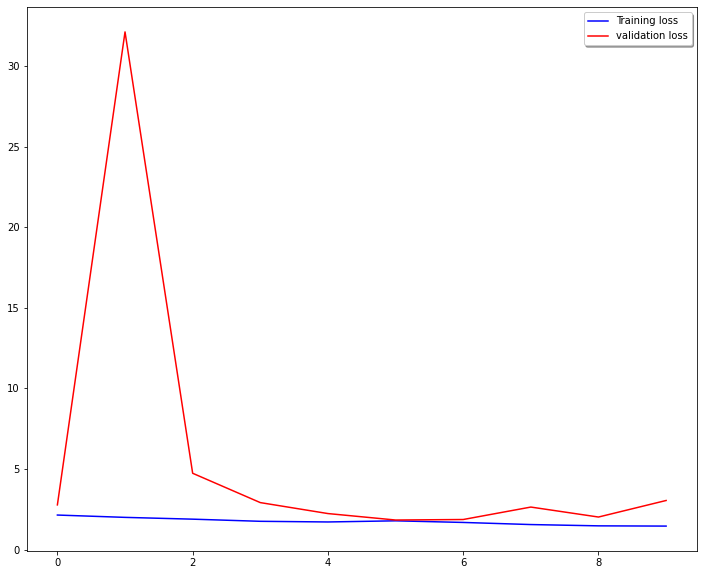

In [9]:
import matplotlib.pyplot as plt

fig = plt.subplots(figsize=(12,10))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="validation loss")
plt.legend(loc='best', shadow=True)